<a href="https://colab.research.google.com/github/Phung-Thu-Trang/Group8-final-project/blob/trang/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Bước 1: Cài Java + PySpark
!apt-get install openjdk-11-jdk -y
!pip install pyspark

# Bước 2: Đặt biến JAVA_HOME
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"

# Bước 3: Tạo SparkSession
from pyspark.sql import SparkSession # Import SparkSession
# Tạo Spark session
spark = SparkSession.builder.appName("IBMStockPrediction").getOrCreate()


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fonts-dejavu-core fonts-dejavu-extra libatk-wrapper-java
  libatk-wrapper-java-jni libxt-dev libxtst6 libxxf86dga1 openjdk-11-jre
  x11-utils
Suggested packages:
  libxt-doc openjdk-11-demo openjdk-11-source visualvm mesa-utils
The following NEW packages will be installed:
  fonts-dejavu-core fonts-dejavu-extra libatk-wrapper-java
  libatk-wrapper-java-jni libxt-dev libxtst6 libxxf86dga1 openjdk-11-jdk
  openjdk-11-jre x11-utils
0 upgraded, 10 newly installed, 0 to remove and 34 not upgraded.
Need to get 6,920 kB of archives.
After this operation, 16.9 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 fonts-dejavu-core all 2.37-2build1 [1,041 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 fonts-dejavu-extra all 2.37-2build1 [2,041 kB]
Get:3 http://archive.ubuntu.com/ubuntu jam

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving IBM_clean (1).csv to IBM_clean (1).csv


In [ ]:
df_spark = spark.read.csv("IBM_clean (1).csv", header=True, inferSchema=True)
df_spark.show()


+----------+------+------+------+------+------+
|      date|  open|  high|   low| close|volume|
+----------+------+------+------+------+------+
|1962-01-02|1.5364|1.5364|1.5191|1.5191|  4063|
|1962-01-03|1.5191|1.5324|1.5191|1.5324|  3047|
|1962-01-04|1.5324|1.5324|1.5164|1.5171|  2735|
|1962-01-05|1.5151|1.5151|1.4845|1.4872|  3828|
|1962-01-08|1.4859|1.4859|1.4474|1.4593|  5703|
|1962-01-09| 1.466|1.4952| 1.466|1.4766|  5157|
|1962-01-10|1.4793|1.4859|1.4793|1.4793|  3125|
|1962-01-11|1.4833|1.4952|1.4833|1.4952|  3360|
|1962-01-12|1.4978|1.5084|1.4978|1.4978|  4609|
|1962-01-15|1.5032|1.5078|1.5032|1.5045|  2656|
|1962-01-16|1.5032|1.5032|1.4886|1.4886|  2656|
|1962-01-17| 1.482| 1.482|1.4607|1.4647|  4375|
|1962-01-18|1.4686|1.4832|1.4686|1.4686|  3906|
|1962-01-19|1.4686|1.4726|1.4526|1.4699|  4219|
|1962-01-22|  1.47|1.4846| 1.466|1.4673|  2891|
|1962-01-23|1.4666|1.4686|  1.45|1.4527|  3906|
|1962-01-24|1.4527|1.4607|1.4454|1.4607|  4297|
|1962-01-25|1.4606|1.4726| 1.442|1.4447|

In [ ]:
# Đọc CSV bằng Spark
df_spark = spark.read.csv("IBM_clean (1).csv", header=True, inferSchema=True)

# Chuyển kiểu ngày tháng nếu cần
from pyspark.sql.functions import to_date

df_spark = df_spark.withColumn("date", to_date("date", "yyyy-MM-dd"))
df_spark = df_spark.orderBy("date")


# Huấn luyện tập train, test


In [ ]:
from pyspark.sql.window import Window
from pyspark.sql.functions import col, avg, stddev, lag


# Thêm cột index để chia theo thứ tự thời gian cho tập train, test
from pyspark.sql.functions import monotonically_increasing_id

df_spark = df_spark.withColumn("idx_temp", monotonically_increasing_id())

# Đếm số dòng và xác định điểm chia
total_rows_initial = df_spark.count()
train_rows_initial = int(total_rows_initial * 0.8)

# Chia DataFrame gốc thành train và test
# train_df_raw sẽ chứa 80% dữ liệu đầu tiên
# test_df_raw sẽ chứa 20% dữ liệu cuối cùng
train_df_raw = df_spark.filter(col("idx_temp") < train_rows_initial).drop("idx_temp")
test_df_raw = df_spark.filter(col("idx_temp") >= train_rows_initial).drop("idx_temp")
from pyspark.sql.window import Window
from pyspark.sql.functions import col, avg, stddev, lag, year, month, dayofmonth, dayofweek, to_date
import pandas as pd
from pyspark.sql.types import StructType # Cần để kết hợp schema
#a. Tạo Đặc trưng cho Tập Huấn luyện (train_df)
print("\nCreating features for Train DataFrame...")
# Tính các đặc trưng trên train_df_raw
# Sử dụng Spark Window functions hoặc chuyển sang Pandas (chỉ với train_df_raw)

# Ví dụ tính trong Spark (ví dụ MA5, Lag1)
window_spec_5_train = Window.orderBy("date").rowsBetween(-4, 0) # Cửa sổ 5 ngày
window_spec_lag_train = Window.orderBy("date") # Cửa sổ cho lag

train_df_features = train_df_raw.withColumn("ma5", avg("close").over(window_spec_5_train))
# Thêm các đặc trưng Spark khác ở đây... price_range, open_close_diff

# Thêm đặc trưng thời gian (dễ dàng)
train_df_features = train_df_features.withColumn("year", year("date"))
train_df_features = train_df_features.withColumn("month", month("date"))
train_df_features = train_df_features.withColumn("day_of_month", dayofmonth("date"))
train_df_features = train_df_features.withColumn("day_of_week", dayofweek("date"))

# Thêm đặc trưng trễ (lag)
lag_days = [1, 5]
lag_cols = ["open", "high", "low", "close", "volume"] # Chỉ các cột gốc
for lag_day in lag_days:
    for col_name in lag_cols:
        new_col_name = f"{col_name}_lag_{lag_day}"
        train_df_features = train_df_features.withColumn(
            new_col_name,
            lag(col(col_name), lag_day).over(window_spec_lag_train)
        )

# Chuyển train_df_raw sang Pandas để tính các chỉ báo phức tạp hơn
train_pandas_raw = train_df_features.toPandas() # Bắt đầu với các đặc trưng Spark đã tính
train_pandas_raw['date'] = pd.to_datetime(train_pandas_raw['date'])
train_pandas_raw = train_pandas_raw.sort_values(by='date') # Đảm bảo sắp xếp

# Tính các chỉ báo Pandas TRÊN train_pandas_raw
# Tính EMA, MACD, BB, Stoch... trên train_pandas_raw
# ... (Copy lại logic tính chỉ báo Pandas của bạn và áp dụng cho train_pandas_raw) ...
train_pandas_raw['EMA12'] = train_pandas_raw['close'].ewm(span=12, adjust=False).mean()
train_pandas_raw['EMA26'] = train_pandas_raw['close'].ewm(span=26, adjust=False).mean()
train_pandas_raw['MACD'] = train_pandas_raw['EMA12'] - train_pandas_raw['EMA26']
train_pandas_raw['MACD_Signal'] = train_pandas_raw['MACD'].ewm(span=9, adjust=False).mean()
train_pandas_raw['MACD_Hist'] = train_pandas_raw['MACD'] - train_pandas_raw['MACD_Signal']
window_bb_pandas = 20
train_pandas_raw['BB_Middle'] = train_pandas_raw['close'].rolling(window=window_bb_pandas).mean()
train_pandas_raw['BB_Std'] = train_pandas_raw['close'].rolling(window=window_bb_pandas).std()
train_pandas_raw['BB_Upper'] = train_pandas_raw['BB_Middle'] + 2 * train_pandas_raw['BB_Std']
train_pandas_raw['BB_Lower'] = train_pandas_raw['BB_Middle'] - 2 * train_pandas_raw['BB_Std']
window_stoch_pandas = 14
train_pandas_raw['LowestLow'] = train_pandas_raw['low'].rolling(window=window_stoch_pandas).min()
train_pandas_raw['HighestHigh'] = train_pandas_raw['high'].rolling(window=window_stoch_pandas).max()
train_pandas_raw['Stoch_K'] = 100 * (train_pandas_raw['close'] - train_pandas_raw['LowestLow']) / (train_pandas_raw['HighestHigh'] - train_pandas_raw['LowestLow'])
train_pandas_raw['Stoch_K'] = train_pandas_raw['Stoch_K'].replace([float('inf'), float('-inf')], pd.NA)
train_pandas_raw['Stoch_D'] = train_pandas_raw['Stoch_K'].rolling(window=3).mean()

# Convert back to Spark DataFrame
train_df_processed = spark.createDataFrame(train_pandas_raw)

# Loại bỏ các dòng có null từ các phép tính cửa sổ/trễ/ewm trong TẬP HUẤN LUYỆN
initial_train_count = train_df_processed.count()
train_df_processed = train_df_processed.na.drop()
print(f"Train rows after feature creation and dropping nulls: {train_df_processed.count()} (dropped {initial_train_count - train_df_processed.count()})")
train_df = train_df_processed # Đổi tên cho dễ dùng

# b. Tạo Đặc trưng cho Tập Kiểm thử (test_df)
print("\nCreating features for Test DataFrame...")
# Đây là phần phức tạp. Cần kết hợp test_df_raw với một phần cuối của train_df_raw

# Xác định số ngày lịch sử cần thiết để tính lại các chỉ báo/lags ở đầu test_df_raw
# Số ngày này phải bằng hoặc lớn hơn cửa sổ lớn nhất của chỉ báo/lag
max_window_or_lag = max(lag_days + [5, 12, 26, window_bb_pandas, window_stoch_pandas]) # Lấy max của tất cả các cửa sổ/lags
history_needed_for_test = max_window_or_lag + 1 # Thêm 1 để đảm bảo đủ cửa sổ


# Lấy phần cuối của train_df_raw
train_tail_spark = train_df_raw.orderBy("date", ascending=False).limit(history_needed_for_test).orderBy("date")


# Kết hợp phần cuối của train_df_raw với test_df_raw
# Sử dụng unionAll
combined_df_for_test_features = train_tail_spark.unionAll(test_df_raw)
print(f"Combined train tail ({train_tail_spark.count()} rows) and raw test ({test_df_raw.count()} rows) for feature calculation.")
print(f"Combined DataFrame count: {combined_df_for_test_features.count()}")


# Bây giờ, tính toán các đặc trưng trên combined_df_for_test_features Tương Tự như đã làm cho train_df
# Quan trọng: Sử dụng CÙNG CÔNG THỨC và CÙNG KÍCH THƯỚC CỬA SỔ/LAGS
window_spec_5_combined = Window.orderBy("date").rowsBetween(-4, 0)
window_spec_lag_combined = Window.orderBy("date")


combined_df_features = combined_df_for_test_features.withColumn("ma5", avg("close").over(window_spec_5_combined))
# Thêm các đặc trưng Spark khác ở đây... price_range, open_close_diff
combined_df_features = combined_df_features.withColumn("year", year("date"))
combined_df_features = combined_df_features.withColumn("month", month("date"))
combined_df_features = combined_df_features.withColumn("day_of_month", dayofmonth("date"))
combined_df_features = combined_df_features.withColumn("day_of_week", dayofweek("date"))

# Thêm đặc trưng trễ (lag)
for lag_day in lag_days:
    for col_name in lag_cols:
        new_col_name = f"{col_name}_lag_{lag_day}"
        combined_df_features = combined_df_features.withColumn(
            new_col_name,
            lag(col(col_name), lag_day).over(window_spec_lag_combined)
        )


# Chuyển sang Pandas để tính các chỉ báo phức tạp hơn
combined_pandas = combined_df_features.toPandas()
combined_pandas['date'] = pd.to_datetime(combined_pandas['date'])
combined_pandas = combined_pandas.sort_values(by='date')

# Tính các chỉ báo Pandas TRÊN combined_pandas
# ... (Copy lại logic tính chỉ báo Pandas và áp dụng cho combined_pandas) ...
combined_pandas['EMA12'] = combined_pandas['close'].ewm(span=12, adjust=False).mean()
combined_pandas['EMA26'] = combined_pandas['close'].ewm(span=26, adjust=False).mean()
combined_pandas['MACD'] = combined_pandas['EMA12'] - combined_pandas['EMA26']
combined_pandas['MACD_Signal'] = combined_pandas['MACD'].ewm(span=9, adjust=False).mean()
combined_pandas['MACD_Hist'] = combined_pandas['MACD'] - combined_pandas['MACD_Signal']
combined_pandas['BB_Middle'] = combined_pandas['close'].rolling(window=window_bb_pandas).mean()
combined_pandas['BB_Std'] = combined_pandas['close'].rolling(window=window_bb_pandas).std()
combined_pandas['BB_Upper'] = combined_pandas['BB_Middle'] + 2 * combined_pandas['BB_Std']
combined_pandas['BB_Lower'] = combined_pandas['BB_Middle'] - 2 * combined_pandas['BB_Std']
combined_pandas['LowestLow'] = combined_pandas['low'].rolling(window=window_stoch_pandas).min()
combined_pandas['HighestHigh'] = combined_pandas['high'].rolling(window=window_stoch_pandas).max()
combined_pandas['Stoch_K'] = 100 * (combined_pandas['close'] - combined_pandas['LowestLow']) / (combined_pandas['HighestHigh'] - combined_pandas['LowestLow'])
combined_pandas['Stoch_K'] = combined_pandas['Stoch_K'].replace([float('inf'), float('-inf')], pd.NA)
combined_pandas['Stoch_D'] = combined_pandas['Stoch_K'].rolling(window=3).mean()


# Convert back to Spark DataFrame
combined_df_processed = spark.createDataFrame(combined_pandas)


# Loại bỏ các dòng CỦA train_tail_spark khỏi DataFrame kết hợp ĐÃ XỬ LÝ
# Chúng ta chỉ cần phần test_df_raw ĐÃ CÓ ĐẶC TRƯNG.
# Sử dụng ngày tháng để lọc
test_start_date = test_df_raw.agg({"date": "min"}).collect()[0][0]

test_df_processed = combined_df_processed.filter(col("date") >= test_start_date)

# Loại bỏ các dòng có null từ các phép tính cửa sổ/trễ/ewm TRONG TẬP KIỂM THỬ
# Các dòng đầu tiên của test_df_processed vẫn có thể có null vì không đủ lịch sử từ phần train_tail_spark
initial_test_count = test_df_processed.count()
test_df_processed = test_df_processed.na.drop()
print(f"Test rows after feature creation and dropping nulls: {test_df_processed.count()} (dropped {initial_test_count - test_df_processed.count()})")
test_df = test_df_processed # Đổi tên cho dễ dùng

# Kiểm tra schema của cả hai DataFrame (phải giống nhau)
print("\nTrain DataFrame schema after processing:")
train_df.printSchema()
print("\nTest DataFrame schema after processing:")
test_df.printSchema()

# Kiểm tra null/inf sau khi xử lý RIÊNG TỪNG TẬP
from pyspark.sql.functions import isnan, when, count, col
# Cần import các hàm này nếu chưa có
from pyspark.sql.functions import isnan, when, count, col

def count_null_inf(df):
    """Counts null, NaN, and infinite values in each column."""
    # Lọc ra chỉ các cột số thực để kiểm tra NaN/Inf, và các cột số nói chung để kiểm tra null
    # Cập nhật để kiểm tra null trên tất cả các kiểu dữ liệu, NaN/Inf chỉ trên số thực
    agg_cols = []
    for c in df.columns:
        # Kiểm tra null cho mọi kiểu dữ liệu
        agg_cols.append(count(when(col(c).isNull(), c)).alias(f"{c}_null"))

        # Kiểm tra NaN và Inf chỉ cho kiểu số thực
        if df.schema[c].dataType in ["double", "float"]:
            agg_cols.append(count(when(isnan(col(c)), c)).alias(f"{c}_NaN"))
            agg_cols.append(count(when(col(c) == float('inf') | col(c) == float('-inf'), c)).alias(f"{c}_Inf"))


    if not agg_cols:
        print("No columns to check.")
        return

    print("Checking for null/NaN/Inf values...")
    df.agg(*agg_cols).show(truncate=False)
print("\nChecking for null/NaN/Inf in processed Train DataFrame:")
count_null_inf(train_df)
print("\nChecking for null/NaN/Inf in processed Test DataFrame:")
count_null_inf(test_df)

# Tính toán volatility5, price_range, open_close_diff trên train_df_processed
window_spec_5_train = Window.orderBy("date").rowsBetween(-4, 0)  # Cửa sổ 5 ngày
train_df_processed = train_df_processed.withColumn("volatility5", stddev("close").over(window_spec_5_train))
train_df_processed = train_df_processed.withColumn("price_range", col("high") - col("low"))
train_df_processed = train_df_processed.withColumn("open_close_diff", col("close") - col("open"))

# Gán lại train_df_processed cho train_df sau khi đã tính toán các đặc trưng mới
train_df = train_df_processed

# *** Thêm các cột volatility5, price_range, open_close_diff vào test_df ***
window_spec_5_test = Window.orderBy("date").rowsBetween(-4, 0)  # Cửa sổ 5 ngày cho test_df
test_df_processed = test_df_processed.withColumn("volatility5", stddev("close").over(window_spec_5_test))
test_df_processed = test_df_processed.withColumn("price_range", col("high") - col("low"))
test_df_processed = test_df_processed.withColumn("open_close_diff", col("close") - col("open"))

# Gán lại test_df_processed cho test_df sau khi đã tính toán các đặc trưng mới
test_df = test_df_processed
from pyspark.ml.feature import VectorAssembler

feature_cols = [
    "high", "low", "volume",
    "ma5", "volatility5", "price_range", "open_close_diff"
    , "MACD", "BB_Upper", "BB_Lower",
    "Stoch_K", "Stoch_D",
    "year", "month",
    "open_lag_5", "high_lag_5", "low_lag_5", "close_lag_5", "volume_lag_5"
]
from pyspark.ml.feature import VectorAssembler, Imputer
# Create an Imputer to replace null values with the mean of the column
imputer = Imputer(
    inputCols=feature_cols,
    outputCols=feature_cols,
    strategy="mean"  # Replace nulls with the mean
)

# Fit the Imputer on the training data
imputer_model = imputer.fit(train_df)

# Transform both training and testing data
train_df = imputer_model.transform(train_df)
test_df = imputer_model.transform(test_df)

# Create the VectorAssembler
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Transform the data
train_df = assembler.transform(train_df)
test_df = assembler.transform(test_df)


Creating features for Train DataFrame...
Train rows after feature creation and dropping nulls: 12718 (dropped 19)

Creating features for Test DataFrame...
Combined train tail (27 rows) and raw test (3185 rows) for feature calculation.
Combined DataFrame count: 3212
Test rows after feature creation and dropping nulls: 3185 (dropped 0)

Train DataFrame schema after processing:
root
 |-- date: timestamp (nullable = true)
 |-- open: double (nullable = true)
 |-- high: double (nullable = true)
 |-- low: double (nullable = true)
 |-- close: double (nullable = true)
 |-- volume: long (nullable = true)
 |-- ma5: double (nullable = true)
 |-- volatility5: double (nullable = true)
 |-- price_range: double (nullable = true)
 |-- open_close_diff: double (nullable = true)
 |-- EMA12: double (nullable = true)
 |-- EMA26: double (nullable = true)
 |-- MACD: double (nullable = true)
 |-- MACD_Signal: double (nullable = true)
 |-- MACD_Hist: double (nullable = true)
 |-- BB_Middle: double (nullable = 

# xây dựng mô hình


In [ ]:
# xây dựng mô hình
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# Cần tìm giá trị regParam tốt nhất thông qua tinh chỉnh siêu tham số.
ridge_lr = LinearRegression(featuresCol="features", labelCol="close",
                            elasticNetParam=0.0, regParam=0.01) # Thử nghiệm với Ridge Regression
# Huấn luyện mô hình Ridge



rf_model = ridge_lr.fit(train_df)



# Đánh giá mô hình


In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator_rmse = RegressionEvaluator(labelCol="close", predictionCol="prediction", metricName="rmse")
evaluator_r2 = RegressionEvaluator(labelCol="close", predictionCol="prediction", metricName="r2")
evaluator_mae = RegressionEvaluator(labelCol="close", predictionCol="prediction", metricName="mae")

# Dự đoán trên tập train & test
train_predictions = rf_model.transform(train_df)
test_predictions = rf_model.transform(test_df)

# Đánh giá tập train
train_rmse = evaluator_rmse.evaluate(train_predictions)
train_r2 = evaluator_r2.evaluate(train_predictions)
train_mae = evaluator_mae.evaluate(train_predictions)

# Đánh giá tập test
test_rmse = evaluator_rmse.evaluate(test_predictions)
test_r2 = evaluator_r2.evaluate(test_predictions)
test_mae = evaluator_mae.evaluate(test_predictions)

print("=== Train Metrics ===")
print(f"Train RMSE: {train_rmse:.2f}")
print(f"Train R²  : {train_r2:.4f}")
print(f"Train MAE : {train_mae:.2f}")

print("\n=== Test Metrics ===")
print(f"Test RMSE: {test_rmse:.2f}")
print(f"Test R²  : {test_r2:.4f}")
print(f"Test MAE : {test_mae:.2f}")


=== Train Metrics ===
Train RMSE: 0.16
Train R²  : 1.0000
Train MAE : 0.09

=== Test Metrics ===
Test RMSE: 0.56
Test R²  : 0.9997
Test MAE : 0.36


In [ ]:
test_predictions.select("date", "close", "prediction").show(10)


+-------------------+-------+------------------+
|               date|  close|        prediction|
+-------------------+-------+------------------+
|2012-09-10 00:00:00|117.446|117.12620472688091|
|2012-09-11 00:00:00|118.802|118.52712994805114|
|2012-09-12 00:00:00|119.094|118.73872410489274|
|2012-09-13 00:00:00|120.608|120.06660484601969|
|2012-09-14 00:00:00|120.871|120.56696951251323|
|2012-09-17 00:00:00| 121.07|121.02068428405816|
|2012-09-18 00:00:00|121.023|120.85859205877746|
|2012-09-19 00:00:00|120.649|120.30570069801972|
|2012-09-20 00:00:00|120.503| 120.5030220234983|
|2012-09-21 00:00:00|120.386| 120.2021205797503|
+-------------------+-------+------------------+
only showing top 10 rows



In [ ]:
import pandas as pd
import numpy as np
from pyspark.sql.functions import when, isnull, lit, col as spark_col
from pyspark.sql.types import DoubleType

# Lấy dữ liệu từ Spark về Pandas và chuẩn bị dữ liệu
latest_data = df_spark.orderBy("date", ascending=True).toPandas().copy()
latest_data['date'] = pd.to_datetime(latest_data['date'])
latest_data = latest_data.sort_values('date')
latest_data = latest_data[feature_cols + ['close', 'date']].dropna().copy()

# Lấy 30 ngày gần nhất làm lịch sử
history = latest_data.iloc[-30:].copy()
future_predictions = []

# Vòng lặp dự báo 20 ngày
for i in range(20):
    last_row = history.iloc[-1]
    next_day = last_row['date'] + pd.Timedelta(days=1)

    # Khởi tạo dòng dữ liệu mới
    new_row = pd.DataFrame([{
        'date': next_day,
        'high': last_row['high'],
        'low': last_row['low'],
        'close': 0.0,
        'volume': last_row['volume']
    }])

    temp_df = pd.concat([history, new_row], ignore_index=True)

    # Tính các chỉ báo kỹ thuật
    temp_df['ma5'] = temp_df['close'].rolling(5, min_periods=1).mean()
    temp_df['volatility5'] = temp_df['close'].rolling(5, min_periods=1).std()
    temp_df['price_range'] = temp_df['high'] - temp_df['low']

    temp_df['BB_Middle'] = temp_df['close'].rolling(20, min_periods=1).mean()
    temp_df['BB_Std'] = temp_df['close'].rolling(20, min_periods=1).std()
    temp_df['BB_Upper'] = temp_df['BB_Middle'] + 2 * temp_df['BB_Std']
    temp_df['BB_Lower'] = temp_df['BB_Middle'] - 2 * temp_df['BB_Std']

    temp_df['EMA12'] = temp_df['close'].ewm(span=12, adjust=False).mean()
    temp_df['EMA26'] = temp_df['close'].ewm(span=26, adjust=False).mean()
    temp_df['MACD'] = temp_df['EMA12'] - temp_df['EMA26']
    temp_df['MACD_Signal'] = temp_df['MACD'].ewm(span=9, adjust=False).mean()
    temp_df['MACD_Hist'] = temp_df['MACD'] - temp_df['MACD_Signal']

    temp_df['LowestLow'] = temp_df['low'].rolling(14, min_periods=1).min()
    temp_df['HighestHigh'] = temp_df['high'].rolling(14, min_periods=1).max()
    temp_df['Stoch_K'] = 100 * (temp_df['close'] - temp_df['LowestLow']) / (temp_df['HighestHigh'] - temp_df['LowestLow'])
    temp_df['Stoch_D'] = temp_df['Stoch_K'].rolling(window=3, min_periods=1).mean()

    temp_df['year'] = temp_df['date'].dt.year
    temp_df['month'] = temp_df['date'].dt.month
    temp_df['day_of_month'] = temp_df['date'].dt.day
    temp_df['day_of_week'] = temp_df['date'].dt.dayofweek + 1

    # Làm sạch dữ liệu
    for col_name in feature_cols:
        temp_df[col_name] = temp_df[col_name].replace([np.inf, -np.inf], np.nan).fillna(0)

    # Chuẩn bị vector đặc trưng cho ngày dự đoán
    latest = temp_df.iloc[-1]
    feature_vector = np.array([latest.get(col, 0.0) for col in feature_cols]).reshape(1, -1)
    feature_df_pd = pd.DataFrame(feature_vector, columns=feature_cols)

    # Bổ sung cột còn thiếu nếu có
    missing_cols = [col for col in feature_cols if col not in feature_df_pd.columns]
    if missing_cols:
        print("⚠️ Thiếu cột:", missing_cols)
        for col in missing_cols:
            feature_df_pd[col] = 0.0

    feature_df_pd = feature_df_pd[feature_cols].astype(np.float64)

    # Tạo Spark DataFrame và ép kiểu
    spark_feature_df = spark.createDataFrame(feature_df_pd)
    for c in spark_feature_df.columns:
        spark_feature_df = spark_feature_df.withColumn(
            c,
            when(isnull(spark_col(c)), lit(0.0)).otherwise(spark_col(c).cast(DoubleType()))
        )

    # Vector hóa và dự đoán
    spark_feature_df = assembler.transform(spark_feature_df)
    prediction = rf_model.transform(spark_feature_df).toPandas().iloc[0]['prediction']

    # Tính phần trăm thay đổi
    percentage_change = (prediction - last_row['close']) / last_row['close']
    future_predictions.append({
        'date': next_day,
        'predicted_close': prediction,
        'percentage_change': percentage_change
    })

    # Làm mượt biến động bằng trung bình 3 ngày gần nhất
    if i >= 3:
        avg_change = np.mean([future_predictions[j]['percentage_change'] for j in range(i - 3, i)])
        percentage_change = (percentage_change + avg_change) / 2

    # Cập nhật close cho new_row
    predicted_close = last_row['close'] * (1 + percentage_change)
    new_row.at[0, 'close'] = predicted_close

    # Thêm new_row vào lịch sử
    history = pd.concat([history, new_row], ignore_index=True)

# Tổng hợp kết quả dự đoán
future_df = pd.DataFrame(future_predictions).sort_values('date')
future_df.to_csv("du_bao_20_ngay_toi.csv", index=False)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Đọc dữ liệu gốc đã dùng để train (giả sử bạn có file CSV hoặc từ train_df)
historical_df = train_df.orderBy("date").toPandas()
historical_df['date'] = pd.to_datetime(historical_df['date'])
historical_df = historical_df[['date', 'close']]

# Đọc dữ liệu dự báo
future_df = pd.read_csv("du_bao_20_ngay_toi.csv", parse_dates=['date'])
future_df = future_df.rename(columns={"predicted_close": "close"})


In [ ]:
future_df

,date,close,percentage_change
0,2025-05-10,244.209687,-0.020025
1,2025-05-11,244.070593,-0.000570
2,2025-05-12,243.608523,-0.001893
3,2025-05-13,242.743238,-0.003552
4,2025-05-14,242.165865,-0.000400
5,2025-05-15,242.068727,0.000402
6,2025-05-16,241.418287,-0.001514
7,2025-05-17,240.557599,-0.003730
8,2025-05-18,239.834434,-0.004618
9,2025-05-19,238.672300,-0.006345


In [ ]:
future_df['close'].min()

230.70715598383643

In [ ]:
future_df['close'].max()

244.20968681982373

In [ ]:
historical_df['type'] = 'Thực tế'


combined_df = pd.concat([historical_df, future_df], ignore_index=True)


In [ ]:
import pandas as pd

# Đảm bảo chuẩn hóa cột ngày
plot_df = df_spark[df_spark['date'] >= '2025-04-01'].toPandas()
plot_df['date'] = pd.to_datetime(plot_df['date']).dt.floor('D')
plot_df['type'] = 'Thực tế'

# Đọc dữ liệu dự báo
future_df = pd.read_csv("du_bao_20_ngay_toi.csv", parse_dates=['date'])
future_df['date'] = future_df['date'].dt.floor('D')
future_df = future_df.rename(columns={'predicted_close': 'close'})
future_df['type'] = 'Dự báo'

# Gộp dữ liệu
combined_df = pd.concat([plot_df[['date', 'close', 'type']], future_df[['date', 'close', 'type']]])
combined_df = combined_df.sort_values('date').reset_index(drop=True)
combined_df.to_csv("du_lieu_gop_thuc_te_va_du_bao.csv", index=False)
print(combined_df.tail(30))



         date       close     type
18 2025-04-28  234.599000  Thực tế
19 2025-04-29  237.807000  Thực tế
20 2025-04-30  240.221000  Thực tế
21 2025-05-01  238.076000  Thực tế
22 2025-05-02  243.927000  Thực tế
23 2025-05-05  247.533000  Thực tế
24 2025-05-06  247.473000  Thực tế
25 2025-05-07  251.695000  Thực tế
26 2025-05-08  252.460000  Thực tế
27 2025-05-09  249.200000  Thực tế
28 2025-05-10  244.209687   Dự báo
29 2025-05-11  244.070593   Dự báo
30 2025-05-12  243.608523   Dự báo
31 2025-05-13  242.743238   Dự báo
32 2025-05-14  242.165865   Dự báo
33 2025-05-15  242.068727   Dự báo
34 2025-05-16  241.418287   Dự báo
35 2025-05-17  240.557599   Dự báo
36 2025-05-18  239.834434   Dự báo
37 2025-05-19  238.672300   Dự báo
38 2025-05-20  236.502605   Dự báo
39 2025-05-21  235.777279   Dự báo
40 2025-05-22  232.760193   Dự báo
41 2025-05-23  232.393135   Dự báo
42 2025-05-24  231.965744   Dự báo
43 2025-05-25  231.554816   Dự báo
44 2025-05-26  231.205842   Dự báo
45 2025-05-27  230.9

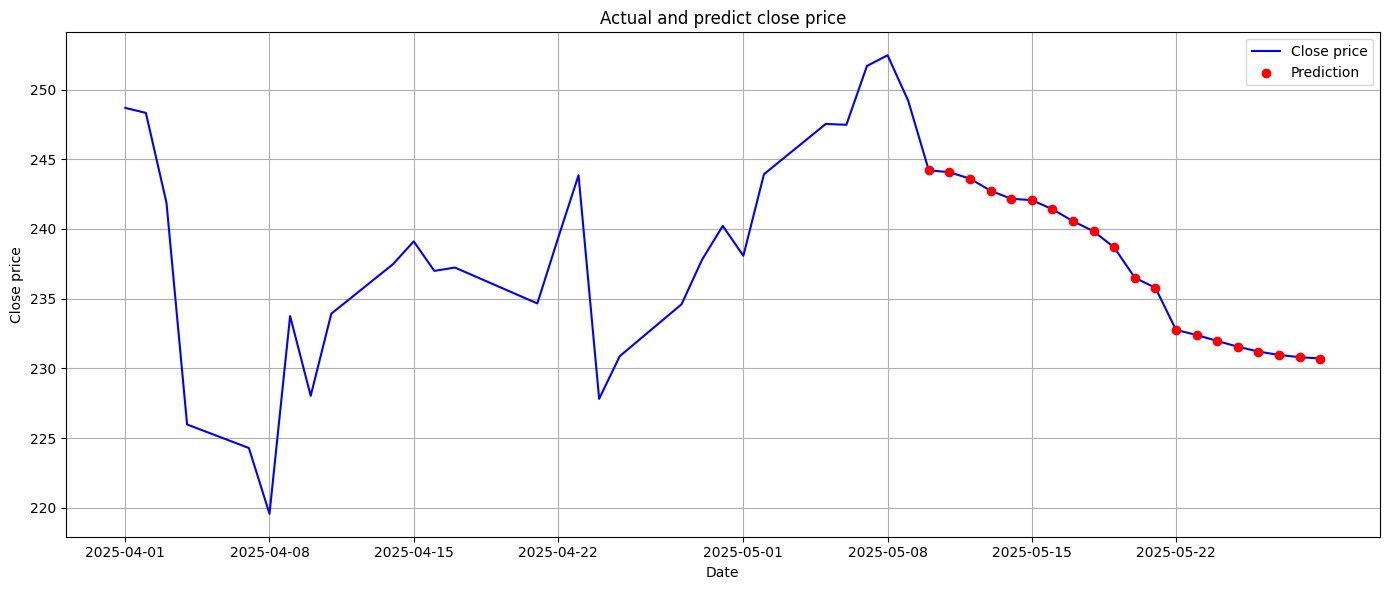

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

# Vẽ đường duy nhất, nối liền cả dữ liệu thực tế và dự báo
plt.plot(combined_df['date'], combined_df['close'], color='blue', label='Close price')
mask_forecast = combined_df['date'] >= pd.to_datetime('2025-05-10')
plt.scatter(combined_df.loc[mask_forecast, 'date'], combined_df.loc[mask_forecast, 'close'],
            color='red', label='Prediction', zorder=5)
plt.xlabel('Date')
plt.ylabel('Close price')
plt.title('Actual and predict close price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# chuyển test sang dạng pandas
test_pd = test_predictions.select("close", "prediction").toPandas()
test_pd['error'] = test_pd['prediction'] - test_pd['close']


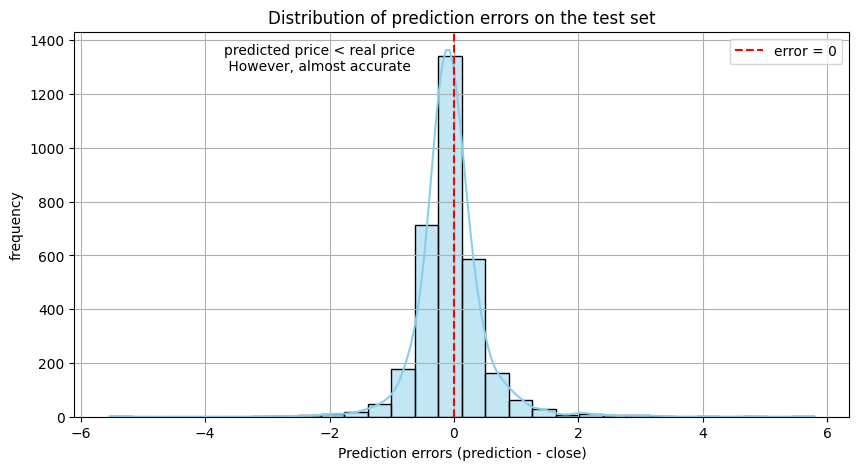

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.histplot(test_pd['error'], bins=30, kde=True, color='skyblue')
plt.axvline(0, color='red', linestyle='--', label='error = 0')

plt.text(-3.7, plt.gca().get_ylim()[1]*0.9, 'predicted price < real price \n However, almost accurate', color='black')

plt.xlabel("Prediction errors (prediction - close)")
plt.ylabel("frequency")
plt.title("Distribution of prediction errors on the test set")
plt.legend()
plt.grid(True)
plt.show()


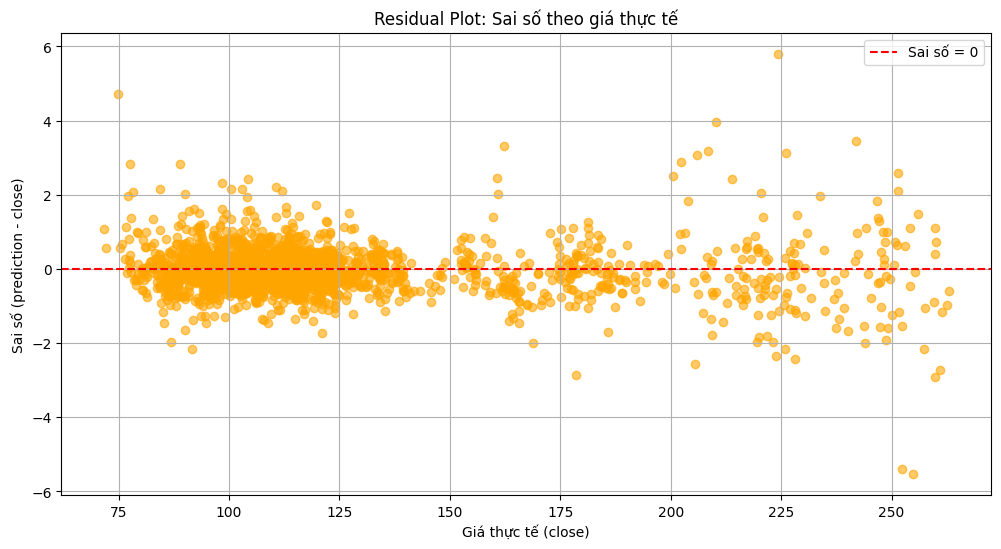

In [ ]:
plt.figure(figsize=(12, 6))
plt.scatter(test_pd['close'], test_pd['error'], alpha=0.6, color='orange')
plt.axhline(0, color='red', linestyle='--', label='Sai số = 0')
plt.xlabel("Giá thực tế (close)")
plt.ylabel("Sai số (prediction - close)")
plt.title("Residual Plot: Sai số theo giá thực tế")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Đảm bảo dữ liệu đã được sắp xếp
combined_df['date'] = pd.to_datetime(combined_df['date'])
combined_df = combined_df.sort_values('date').reset_index(drop=True)

# Tính Bollinger Bands
combined_df['BB_Middle'] = combined_df['close'].rolling(window=20).mean()
combined_df['BB_Std'] = combined_df['close'].rolling(window=20).std()
combined_df['BB_Upper'] = combined_df['BB_Middle'] + 2 * combined_df['BB_Std']
combined_df['BB_Lower'] = combined_df['BB_Middle'] - 2 * combined_df['BB_Std']

# Tính MACD
combined_df['EMA12'] = combined_df['close'].ewm(span=12, adjust=False).mean()
combined_df['EMA26'] = combined_df['close'].ewm(span=26, adjust=False).mean()
combined_df['MACD'] = combined_df['EMA12'] - combined_df['EMA26']
combined_df['MACD_Signal'] = combined_df['MACD'].ewm(span=9, adjust=False).mean()
combined_df['MACD_Hist'] = combined_df['MACD'] - combined_df['MACD_Signal']


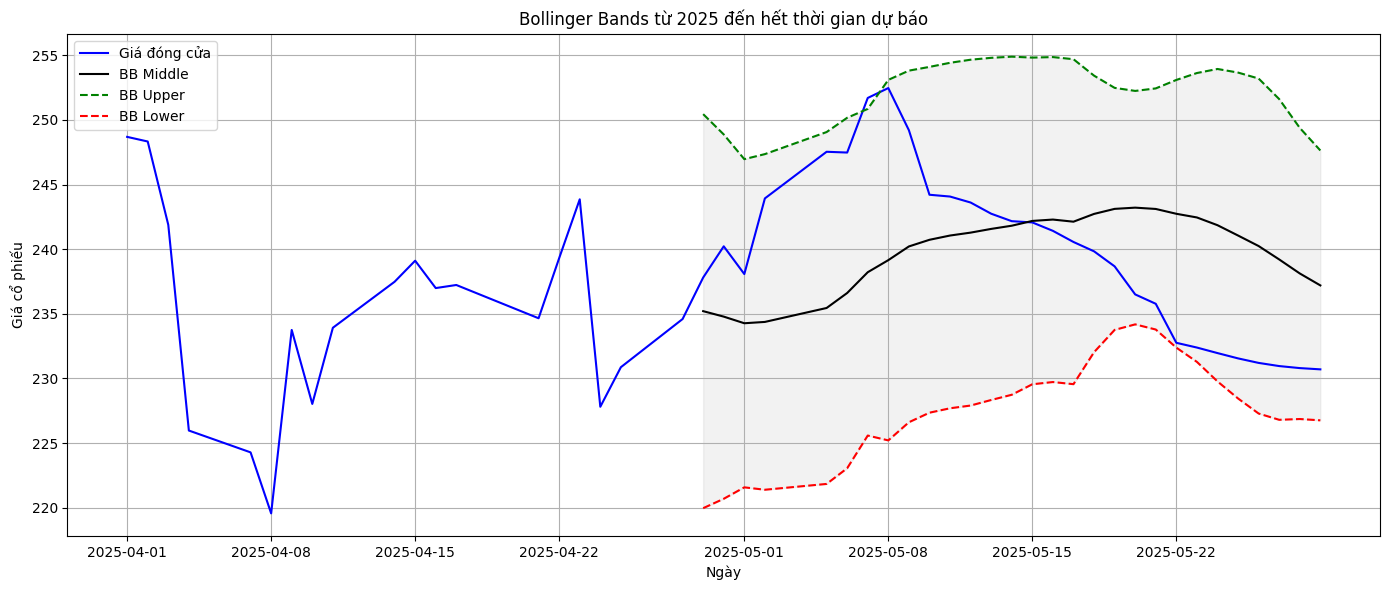

In [ ]:
plt.figure(figsize=(14, 6))
plt.plot(combined_df['date'], combined_df['close'], label='Giá đóng cửa', color='blue')
plt.plot(combined_df['date'], combined_df['BB_Middle'], label='BB Middle', color='black')
plt.plot(combined_df['date'], combined_df['BB_Upper'], label='BB Upper', color='green', linestyle='--')
plt.plot(combined_df['date'], combined_df['BB_Lower'], label='BB Lower', color='red', linestyle='--')
plt.fill_between(combined_df['date'], combined_df['BB_Lower'], combined_df['BB_Upper'], color='gray', alpha=0.1)
plt.title('Bollinger Bands từ 2025 đến hết thời gian dự báo')
plt.xlabel('Ngày')
plt.ylabel('Giá cổ phiếu')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


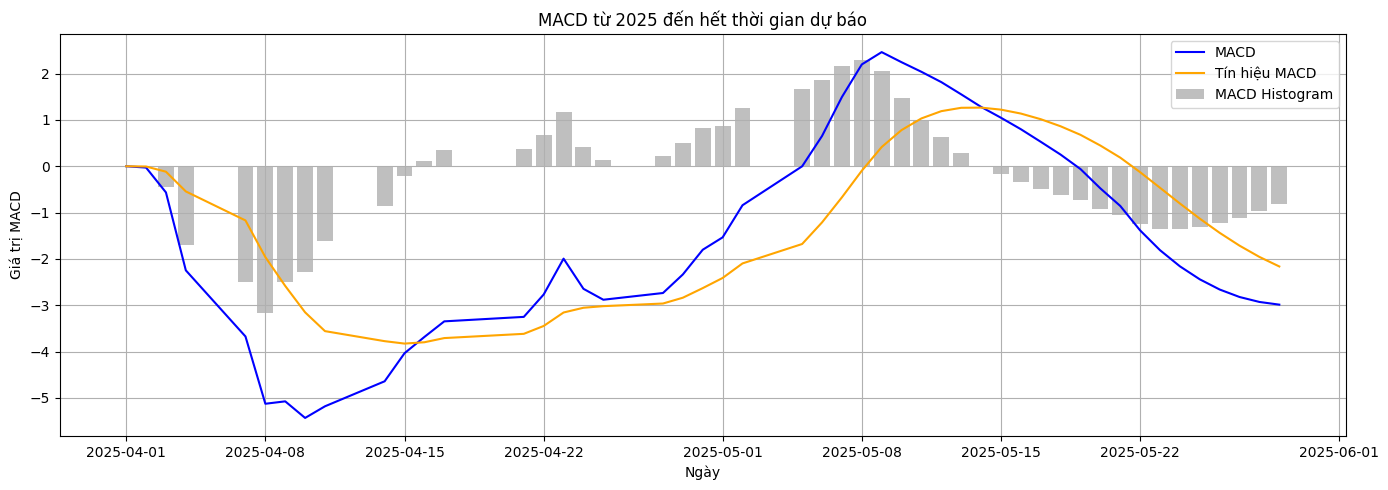

In [ ]:
plt.figure(figsize=(14, 5))
plt.plot(combined_df['date'], combined_df['MACD'], label='MACD', color='blue')
plt.plot(combined_df['date'], combined_df['MACD_Signal'], label='Tín hiệu MACD', color='orange')
plt.bar(combined_df['date'], combined_df['MACD_Hist'], label='MACD Histogram', color='gray', alpha=0.5)
plt.title('MACD từ 2025 đến hết thời gian dự báo')
plt.xlabel('Ngày')
plt.ylabel('Giá trị MACD')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
